In [1]:
import cv2
import numpy as np
import PIL
from PIL import Image
import shutil,os,sys
import glob
from time import sleep
import time

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as ImagePG

## 影像處理(先處理再比對 function)

In [16]:
#圖片,要不要存檔
def ImageProcess(imgpath,switch):
    img=cv2.imread(imgpath)
    Lower = np.array([0, 0, 100])
    Upper = np.array([40, 40, 255])
    
    #//////邊緣偵測//////
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #模糊參數
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    #邊緣檢測參數(門檻1,門檻2)
    img_canny = cv2.Canny(blurred, 10, 60)
    #//////邊緣偵測//////
    
    #//////影像梯度////////
    #Sobelx運算x軸，計算水平
    sobelx=cv2.Sobel(img,cv2.CV_64F,1,0,ksize=3)
    #cv_show(sobelx,'sobelx1')

    #取絕對值
    sobelx=cv2.Sobel(img,cv2.CV_64F,1,0,ksize=3)
    sobelx=cv2.convertScaleAbs(sobelx)
    #cv_show(sobelx,'sobelx2')

    #Sobelx運算y軸，計算垂直
    sobely=cv2.Sobel(img,cv2.CV_64F,0,1,ksize=3)
    sobely=cv2.convertScaleAbs(sobely)
    #cv_show(sobely,'sobely')

    #求和
    sobelAdd=cv2.addWeighted(sobelx,0.5,sobelx,0.5,0)
    #//////影像梯度////////
    
    #/////Laplacian//////
    gray_lap = cv2.Laplacian(img, cv2.CV_16S, ksize=3)
    dst = cv2.convertScaleAbs(gray_lap) # 轉回uint8
    #/////Laplacian//////
    
    #/////存檔/////
    if switch == 1:
        #////測試流水號取檔名/////
        #resulttime = time.strftime("%M_%S_",time.localtime())
        #outname="_"+str('{:0>3d}').format(1)+'.jpg'
        #cv2.imwrite('Screen/transport/'+resulttime+"1_"+outname,img_canny)
        #////測試流水號取檔名/////
        #取檔案名
        #split處理檔名
        cv2.imwrite('Screen/transport/'+"1_"+imgpath.split("/")[-1],img_canny)
        cv2.imwrite('Screen/transport/'+"2_"+imgpath.split("/")[-1],dst)
        cv2.imwrite('Screen/transport/'+"3_"+imgpath.split("/")[-1],sobelAdd)
        
    #/////存檔/////
    '''
    while True:
        cv2.imshow('sobel',sobelAdd)
        cv2.imshow('OGImage',img)
        cv2.imshow('canny',img_canny)
        cv2.imshow('Laplacian',dst)
        k = cv2.waitKey(0)
        if k == 27:
            cv2.destroyAllWindows()
            break
    '''

In [105]:
#用numpy讀檔案
#沒切
#處理影像function
ImageProcess('Screen/scan218.jpg',1)
#有切
#處理影像function
ImageProcess('Screen/scan228.jpg',1)

# CheckSum 比對2圖方法

In [6]:
 # 平均雜湊演算法計算 
def classify_aHash(image1,image2): 
    image1 = cv2.resize(image1,(8,8)) 
    image2 = cv2.resize(image2,(8,8)) 
    gray1 = cv2.cvtColor(image1,cv2.COLOR_BGR2GRAY) 
    gray2 = cv2.cvtColor(image2,cv2.COLOR_BGR2GRAY) 
    hash1 = getHash(gray1) 
    hash2 = getHash(gray2) 
    return Hamming_distance(hash1,hash2) 
 
def classify_pHash(image1,image2): 
    image1 = cv2.resize(image1,(32,32)) 
    image2 = cv2.resize(image2,(32,32)) 
    gray1 = cv2.cvtColor(image1,cv2.COLOR_BGR2GRAY) 
    gray2 = cv2.cvtColor(image2,cv2.COLOR_BGR2GRAY) 
    # 將灰度圖轉為浮點型，再進行dct變換 
    dct1 = cv2.dct(np.float32(gray1)) 
    dct2 = cv2.dct(np.float32(gray2)) 
    # 取左上角的8*8，這些代表圖片的最低頻率 
    # 這個操作等價於c++中利用opencv實現的掩碼操作 
    # 在python中進行掩碼操作，可以直接這樣取出影象矩陣的某一部分 
    dct1_roi = dct1[0:8,0:8] 
    dct2_roi = dct2[0:8,0:8] 
    hash1 = getHash(dct1_roi) 
    hash2 = getHash(dct2_roi) 
    return Hamming_distance(hash1,hash2) 
 
# 輸入灰度圖，返回hash 
def getHash(image): 
    avreage = np.mean(image) 
    hash = [] 
    for i in range(image.shape[0]): 
        for j in range(image.shape[1]): 
            if image[i,j] > avreage: 
                hash.append(1) 
            else: 
                hash.append(0) 
    return hash 
 
#計算漢明距離 
def Hamming_distance(hash1,hash2): 
    num = 0 
    for index in range(len(hash1)): 
        if hash1[index] != hash2[index]: 
            num += 1 
            return num 

### CheckSum-計算每個通道的直方圖相似值

In [81]:
# 通過得到每個通道的直方圖來計算相似度 
def classify_hist_with_split(image1,image2): 
# 將影象resize後，分離為三個通道，再計算每個通道的相似值 
    #也可當Input參數
    size = (256,256)
    image1 = cv2.resize(image1,size) 
    image2 = cv2.resize(image2,size) 
    sub_image1 = cv2.split(image1) 
    sub_image2 = cv2.split(image2) 
    sub_data = 0 
    for im1,im2 in zip(sub_image1,sub_image2): 
        sub_data += calculate(im1,im2) 
        sub_data = sub_data/3 
    return sub_data 

### CheckSum-計算單通道的直方圖的相似值 

In [18]:
# 計算單通道的直方圖的相似值 
def calculate(image1,image2): 
    #cv2.calcHist(影像, 通道, 遮罩, 區間數量, 數值範圍)
    hist1 = cv2.calcHist([image1],[0],None,[256],[0.0,255.0]) 
    hist2 = cv2.calcHist([image2],[0],None,[256],[0.0,255.0]) 
    #////Test///比較因子
    '''
    print("相比大於algo",(hist1>=hist2).all())
    print("相比小於於algo",(hist1<=hist2).all())
    print("相比相似algo",(hist1==hist2).all())
    '''
    # 可以比較下直方圖 
    
    plt.plot(range(256),hist1,'r') 
    plt.plot(range(256),hist2,'b') 
    plt.show() 
    
    # 計算直方圖的重合度 
    degree = 0 
    for i in range(len(hist1)): 
        if hist1[i] != hist2[i]: 
            degree = degree + (1 - abs(hist1[i]-hist2[i])/max(hist1[i],hist2[i])) 
        else: 
            degree = degree + 1 
    degree = degree/len(hist1)
    
    #遞迴求比較值
    #rate=calculate('Screen/transport/46_44_2__001.jpg','Screen/transport/46_45_2__001.jpg')
    return degree 

### 比較測試(設定門檻去比較)

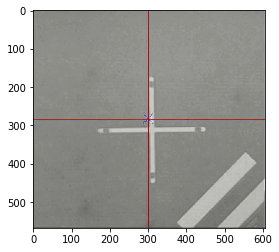

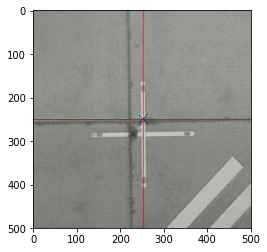

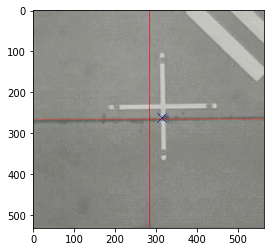

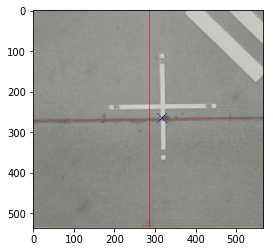

In [4]:
file='Screen/scan218.jpg'
file2='Screen/scan228.jpg'
file3='Screen/scan231.jpg'
file4='Screen/scan232.jpg'
image = ImagePG.imread(file)
image2 = ImagePG.imread(file2)
image3 = ImagePG.imread(file3)
image4 = ImagePG.imread(file4)
plt.imshow(image)
plt.show()
plt.imshow(image2)
plt.show()
plt.imshow(image3)
plt.show()
plt.imshow(image4)
plt.show()

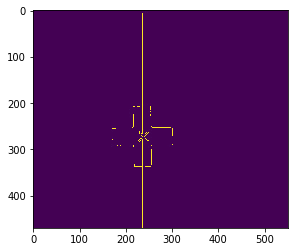

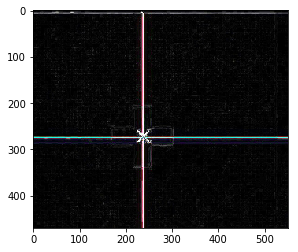

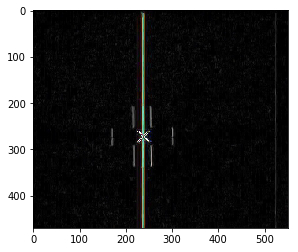

In [5]:
file5='Screen/transport/1_scan001.jpg'
file6='Screen/transport/2_scan001.jpg'
file7='Screen/transport/3_scan001.jpg'
image5 = ImagePG.imread(file5)
image6 = ImagePG.imread(file6)
image7 = ImagePG.imread(file7)
plt.imshow(image5)
plt.show()
plt.imshow(image6)
plt.show()
plt.imshow(image7)
plt.show()

## 合併成[比對演算法]

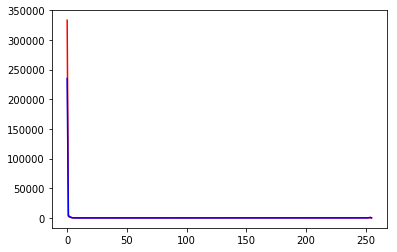

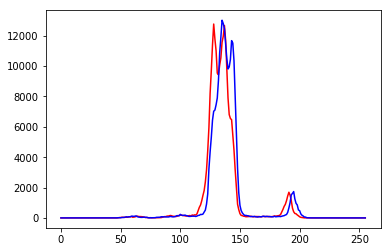

False
執行時間：0.279740 秒
[0.96958995]
[0.67193174]


In [20]:
#單改一張大小
def ChangeSize(filename):
        img=Image.open(filename)
        #尺寸轉換200x200
        img_new=img.resize((500,500),PIL.Image.ANTIALIAS)
        img_new.save('Screen/transport/'+filename.split("/")[-1] )

#1.0
'''
rate1=calculate(cv2.imread('Screen/transport/46_44_2__001.jpg'),
                cv2.imread('Screen/transport/46_44_2__001.jpg'))
'''
#//////////////////////////////////////////////////////
start = time.time()
#Input
file='Screen/scan231.jpg'
file2='Screen/scan232.jpg'
#統一大小
ChangeSize(file)
ChangeSize(file2)
#處理影像
ImageProcess(file,1)
ImageProcess(file2,1)
#設門檻0.969
rate2=calculate(cv2.imread('Screen/transport/46_44_1__001.jpg'),
                cv2.imread('Screen/transport/46_45_1__001.jpg'))

#比對兩張相似度
rate3=calculate(cv2.imread('Screen/transport/'+file.split("/")[-1]),
                cv2.imread('Screen/transport/'+file2.split("/")[-1]))

#相似度再比對門檻值0.969
if rate3<rate2:
    print(False)
if rate3>rate2:
    print(True)

end=time.time()
print("執行時間：%f 秒" % (end - start))
#//////////////////////////////////////////////////////
print(rate2)
print(rate3)

### CheckSum-灰度直方圖的重和度

In [38]:
# 灰度直方圖作為相似比較
def classify_gray_hist(image1,image2,size = (256,256)): 
    degree = 0 
# 先計算直方圖 
# 幾個引數必須用方括號括起來 
# 這裡直接用灰度圖計算直方圖，所以是使用第一個通道， 
# 也可以進行通道分離後，得到多個通道的直方圖 
# bins 取為16 
    image1 = cv2.resize(image1,size) 
    image2 = cv2.resize(image2,size) 
    hist1 = cv2.calcHist([image1],[0],None,[256],[0.0,255.0]) 
    hist2 = cv2.calcHist([image2],[0],None,[256],[0.0,255.0]) 
# 計算直方圖的重合度 
    for i in range(len(hist1)):
            if hist1[i] != hist2[i]:
                degree = degree + (1 - abs(hist1[i]-hist2[i])/max(hist1[i],hist2[i]))
            else:
                degree = degree + 1 
    degree = degree/len(hist1) 
    return degree 
    

## 使用比對function

In [15]:
def Comparison(OG_image,Comparison_image):
    img1 = cv2.imread(OG_image) 
    img2 = cv2.imread(Comparison_image) 
    #畫圖 
    #算數字
    degree1=calculate(img1,img2)
    #degree2=classify_hist_with_split(img1,img2)
    #degree = classify_hist_with_split(img1,img2) 
    degree3 = classify_aHash(img1,img2) 
    degree4 = classify_pHash(img1,img2) 
    print (degree1)
    #print (degree2)
    print (degree3)
    print (degree4)
    print("---------------")    

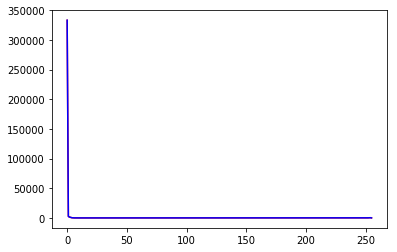

1.0
None
None
---------------


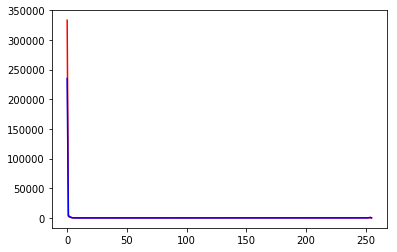

[0.96958995]
1
1
---------------


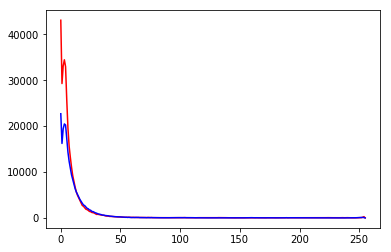

[0.654126]
1
1
---------------


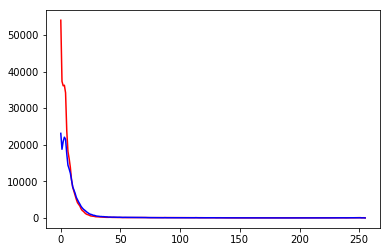

[0.64586663]
1
1
---------------
執行時間：0.483559 秒


In [93]:
#測試function
start = time.time()

#同一張canny
rate1=Comparison('Screen/transport/46_44_1__001.jpg','Screen/transport/46_44_1__001.jpg')

#有切沒切 canny
rate2=Comparison('Screen/transport/46_44_1__001.jpg','Screen/transport/46_45_1__001.jpg')

#有切沒切 laplacian
rate3=Comparison('Screen/transport/46_44_2__001.jpg','Screen/transport/46_45_2__001.jpg')

#有切沒切 Sobel
rate4=Comparison('Screen/transport/46_44_3__001.jpg','Screen/transport/46_45_3__001.jpg')

#都切，前後差一秒
#rate2=Comparison('Screen\scan217.jpg','Screen/scan218.jpg')

end=time.time()
print("執行時間：%f 秒" % (end - start))

### 測試單純截圖(壞掉)

In [ ]:
i=0
'''
while True:
    if cv2.waitKey(1) == ord('a'):
        path='Screen\\'
        time=time.strftime("%M:%S %p", time.localtime())
        filename=str('{:0>3d}'+time).format(i+1)
        Scann_Aera(path,filename,switch,100,250,650,720)
    cv2.destroyAllWindows()
    if key == 113 or key==81:  #按 q 鍵結束
        break
'''
cap = cv2.VideoCapture('x-ray/2021-02-19 11-29-36  T111043BA.mp4')
print("Start")
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Eed")
        break
    cv2.imshow('frame', frame)
    key = cv2.waitKey(0)
    if key == 113:
        path='Screen\\'
        time=time.strftime("%M:%S %p", time.localtime())
        filename=str('{:0>3d}'+time).format(i+1)
        Scann_Aera(path,filename,1,100,250,650,720)
    if key==81:
        print("Eed")
        break
cap.release()
cv2.destroyAllWindows()